# Snapshot Characterization: State of the Token Cloud

**A comprehensive observational survey of token embedding structure at any point in time.**

This notebook takes a single embedding matrix snapshot and runs the full battery of geometric/statistical tests to characterize its structure. Use it to compare:
- Training snapshots at different times (t=0, t=1000, t=100k)
- Different training runs (SGD vs Adam, different learning rates)
- Trained models (Qwen, GPT, etc.) vs untrained

## Questions We Answer

1. **Distribution:** What does the L2 norm histogram look like?
2. **Separation:** Are dead/live tokens geometrically separated?
3. **Structure:** Tight cluster? Dispersed cloud? Crystals?
4. **Connectivity:** Are tokens still neighbors or fragmented?
5. **Dimensionality:** How many effective dimensions are in use?
6. **Directionality:** Are tokens spread uniformly or clustered in certain directions?
7. **Scale:** What are typical inter-token distances?

## Parameters

In [25]:
# Data source - can be:
# 1. Training snapshot: point to safetensors file + specify step index
# 2. Saved embedding matrix: point to safetensors with just 'W' key

# Example 1: Training snapshot at specific step
DATA_SOURCE = 'training_snapshot'
TRAINING_DATA_PATH = '../tensors/Lil_Gatsby/1.9c_training_data.safetensors'
SNAPSHOT_STEP = 1000  # Which step to analyze
RUN_NAME = '1.9c at step 1000 (Adam, lr=1e-3)'

# Example 2: Standalone embedding matrix (uncomment to use)
# DATA_SOURCE = 'embedding_matrix'
# EMBEDDING_PATH = '../tensors/qwen_3_4b_W.safetensors'
# RUN_NAME = 'Qwen 3 4B Instruct'

# Analysis parameters
NEAREST_NEIGHBOR_K = 5  # For connectivity analysis
DISTANCE_THRESHOLD = 0.01  # For connectivity graph (tokens within this distance are "connected")

# Visualization
DPI = 75
COLORMAP = 'inferno'

## Imports

In [26]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import describe
from sklearn.decomposition import PCA

## Device Detection

In [27]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

Using device: mps


## Load Data

In [28]:
print(f'Loading: {RUN_NAME}')
print(f'Source: {DATA_SOURCE}')
print()

if DATA_SOURCE == 'training_snapshot':
    data = load_file(TRAINING_DATA_PATH)
    W = data['embeddings'][SNAPSHOT_STEP].cpu().numpy()  # (128, 64)
    
    # Load token categories if available
    DEAD_TOKENS = data['dead_token_ids'].cpu().numpy() if 'dead_token_ids' in data else None
    LIVE_TOKENS = data['live_token_ids'].cpu().numpy() if 'live_token_ids' in data else None
    
    print(f'Loaded training snapshot at step {SNAPSHOT_STEP}')
    
elif DATA_SOURCE == 'embedding_matrix':
    data = load_file(EMBEDDING_PATH)
    W = data['W'].cpu().numpy() if 'W' in data else data['embeddings'].cpu().numpy()
    
    # Try to load token categories
    DEAD_TOKENS = data['dead_token_ids'].cpu().numpy() if 'dead_token_ids' in data else None
    LIVE_TOKENS = data['live_token_ids'].cpu().numpy() if 'live_token_ids' in data else None
    
    print(f'Loaded embedding matrix')
    
else:
    raise ValueError(f'Unknown DATA_SOURCE: {DATA_SOURCE}')

if DEAD_TOKENS is not None:
    print(f'  Dead tokens: {len(DEAD_TOKENS)}')
if LIVE_TOKENS is not None:
    print(f'  Live tokens: {len(LIVE_TOKENS)}')

print()
print(f'Embedding matrix shape: {W.shape}')
print(f'  Vocab size: {W.shape[0]}')
print(f'  Embedding dim: {W.shape[1]}')

n_tokens = W.shape[0]
embedding_dim = W.shape[1]

Loading: 1.9c at step 1000 (Adam, lr=1e-3)
Source: training_snapshot

Loaded training snapshot at step 1000
  Dead tokens: 50
  Live tokens: 78

Embedding matrix shape: (128, 64)
  Vocab size: 128
  Embedding dim: 64


## 1. L2 Norm Distribution

1. L2 NORM DISTRIBUTION

Norm statistics:
  Mean: 0.888141
  Std: 0.130560
  Min: 0.800869
  Max: 1.297313
  Median: 0.810017

Dead tokens (50):
  Mean norm: 0.809966
  Std: 0.000020

Live tokens (78):
  Mean norm: 0.938253
  Std: 0.146780



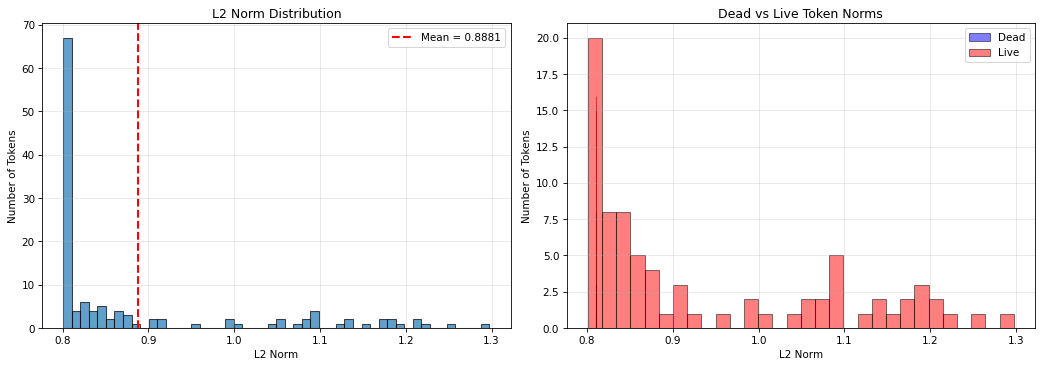

In [29]:
print('='*70)
print('1. L2 NORM DISTRIBUTION')
print('='*70)
print()

norms = np.linalg.norm(W, axis=1)  # (n_tokens,)

print(f'Norm statistics:')
print(f'  Mean: {norms.mean():.6f}')
print(f'  Std: {norms.std():.6f}')
print(f'  Min: {norms.min():.6f}')
print(f'  Max: {norms.max():.6f}')
print(f'  Median: {np.median(norms):.6f}')
print()

if DEAD_TOKENS is not None and LIVE_TOKENS is not None:
    dead_mask = np.isin(np.arange(n_tokens), DEAD_TOKENS)
    live_mask = np.isin(np.arange(n_tokens), LIVE_TOKENS)
    
    print(f'Dead tokens ({len(DEAD_TOKENS)}):')
    print(f'  Mean norm: {norms[dead_mask].mean():.6f}')
    print(f'  Std: {norms[dead_mask].std():.6f}')
    print()
    print(f'Live tokens ({len(LIVE_TOKENS)}):')
    print(f'  Mean norm: {norms[live_mask].mean():.6f}')
    print(f'  Std: {norms[live_mask].std():.6f}')
    print()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Left: Overall histogram
ax = axes[0]
ax.hist(norms, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(norms.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean = {norms.mean():.4f}')
ax.set_xlabel('L2 Norm')
ax.set_ylabel('Number of Tokens')
ax.set_title('L2 Norm Distribution')
ax.legend()
ax.grid(alpha=0.3)

# Right: Dead vs live (if available)
ax = axes[1]
if DEAD_TOKENS is not None and LIVE_TOKENS is not None:
    ax.hist(norms[dead_mask], bins=30, alpha=0.5, label='Dead', color='blue', edgecolor='black')
    ax.hist(norms[live_mask], bins=30, alpha=0.5, label='Live', color='red', edgecolor='black')
    ax.set_xlabel('L2 Norm')
    ax.set_ylabel('Number of Tokens')
    ax.set_title('Dead vs Live Token Norms')
    ax.legend()
else:
    ax.text(0.5, 0.5, 'No dead/live labels available', 
            ha='center', va='center', transform=ax.transAxes)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('='*70)

## 2. Pairwise Distance Distribution

2. PAIRWISE DISTANCE DISTRIBUTION

Computing pairwise distances... (this may take a moment)
✓ Computed 8128 pairwise distances

Distance statistics:
  Mean: 0.305934
  Std: 0.267957
  Min: 0.000000
  Max: 0.924704
  Median: 0.271790



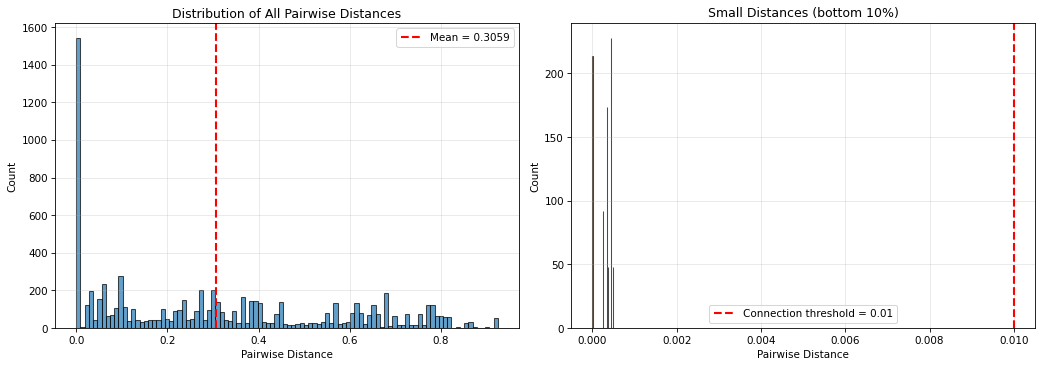

In [30]:
print('='*70)
print('2. PAIRWISE DISTANCE DISTRIBUTION')
print('='*70)
print()

print('Computing pairwise distances... (this may take a moment)')
distances_condensed = pdist(W, metric='euclidean')  # Condensed distance matrix
distances_matrix = squareform(distances_condensed)  # Full matrix

print(f'✓ Computed {len(distances_condensed)} pairwise distances')
print()

print('Distance statistics:')
print(f'  Mean: {distances_condensed.mean():.6f}')
print(f'  Std: {distances_condensed.std():.6f}')
print(f'  Min: {distances_condensed.min():.6f}')
print(f'  Max: {distances_condensed.max():.6f}')
print(f'  Median: {np.median(distances_condensed):.6f}')
print()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Left: Distance histogram
ax = axes[0]
ax.hist(distances_condensed, bins=100, edgecolor='black', alpha=0.7)
ax.axvline(distances_condensed.mean(), color='r', linestyle='--', linewidth=2, 
           label=f'Mean = {distances_condensed.mean():.4f}')
ax.set_xlabel('Pairwise Distance')
ax.set_ylabel('Count')
ax.set_title('Distribution of All Pairwise Distances')
ax.legend()
ax.grid(alpha=0.3)

# Right: Zoom on small distances (structure)
ax = axes[1]
small_distances = distances_condensed[distances_condensed < np.percentile(distances_condensed, 10)]
ax.hist(small_distances, bins=50, edgecolor='black', alpha=0.7, color='orange')
ax.axvline(DISTANCE_THRESHOLD, color='r', linestyle='--', linewidth=2,
           label=f'Connection threshold = {DISTANCE_THRESHOLD}')
ax.set_xlabel('Pairwise Distance')
ax.set_ylabel('Count')
ax.set_title('Small Distances (bottom 10%)')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('='*70)

## 3. Nearest Neighbor Analysis

3. NEAREST NEIGHBOR ANALYSIS

Nearest neighbor distances (k=5):
  Rank 1: mean=0.025951, median=0.023044
  Rank 2: mean=0.026905, median=0.028319
  Rank 3: mean=0.029772, median=0.027238
  Rank 4: mean=0.031770, median=0.033105
  Rank 5: mean=0.033817, median=0.032803

Tokens with nearest neighbor < 0.01: 58/128 (45.3%)



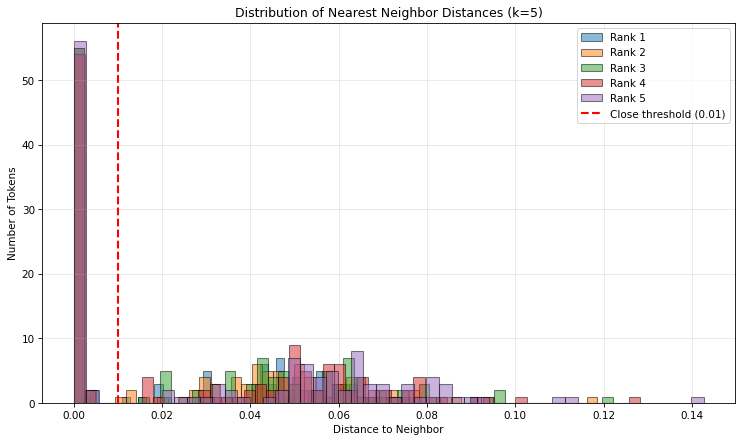

In [31]:
print('='*70)
print('3. NEAREST NEIGHBOR ANALYSIS')
print('='*70)
print()

# For each token, find k nearest neighbors
k = NEAREST_NEIGHBOR_K
nearest_distances = np.zeros((n_tokens, k))

for i in range(n_tokens):
    # Get distances to all other tokens (excluding self)
    dists = distances_matrix[i, :]
    dists[i] = np.inf  # Exclude self
    
    # Find k smallest
    nearest_indices = np.argpartition(dists, k)[:k]
    nearest_distances[i] = dists[nearest_indices]

# Statistics per neighbor rank
print(f'Nearest neighbor distances (k={k}):')
for rank in range(k):
    dists_at_rank = nearest_distances[:, rank]
    print(f'  Rank {rank+1}: mean={dists_at_rank.mean():.6f}, median={np.median(dists_at_rank):.6f}')
print()

# How many tokens have very close neighbors?
close_threshold = DISTANCE_THRESHOLD
tokens_with_close_neighbor = (nearest_distances[:, 0] < close_threshold).sum()
print(f'Tokens with nearest neighbor < {close_threshold}: {tokens_with_close_neighbor}/{n_tokens} ({tokens_with_close_neighbor/n_tokens:.1%})')
print()

# Visualization
fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

for rank in range(k):
    ax.hist(nearest_distances[:, rank], bins=50, alpha=0.5, 
            label=f'Rank {rank+1}', edgecolor='black')

ax.axvline(close_threshold, color='r', linestyle='--', linewidth=2,
           label=f'Close threshold ({close_threshold})')
ax.set_xlabel('Distance to Neighbor')
ax.set_ylabel('Number of Tokens')
ax.set_title(f'Distribution of Nearest Neighbor Distances (k={k})')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('='*70)

## 4. Connectivity Graph

4. CONNECTIVITY GRAPH

Threshold: 0.01
Edges: 1329
Average degree: 20.77
Max degree: 55
Isolated nodes (degree 0): 69

Connected components: 71
Largest component: 56 tokens
Second largest: 3 tokens
Singletons: 69



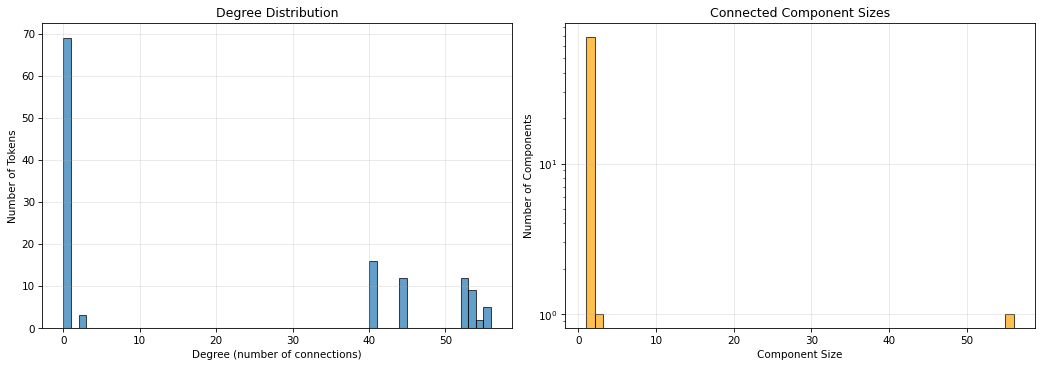

In [32]:
print('='*70)
print('4. CONNECTIVITY GRAPH')
print('='*70)
print()

# Build adjacency matrix: tokens are "connected" if distance < threshold
adjacency = (distances_matrix < DISTANCE_THRESHOLD) & (distances_matrix > 0)  # Exclude self-connections

# Graph statistics
n_edges = adjacency.sum() // 2  # Divide by 2 since matrix is symmetric
degrees = adjacency.sum(axis=1)

print(f'Threshold: {DISTANCE_THRESHOLD}')
print(f'Edges: {n_edges}')
print(f'Average degree: {degrees.mean():.2f}')
print(f'Max degree: {degrees.max()}')
print(f'Isolated nodes (degree 0): {(degrees == 0).sum()}')
print()

# Find connected components (simple flood fill)
visited = np.zeros(n_tokens, dtype=bool)
components = []

for start in range(n_tokens):
    if visited[start]:
        continue
    
    # BFS from start
    component = []
    queue = [start]
    visited[start] = True
    
    while queue:
        node = queue.pop(0)
        component.append(node)
        
        # Add unvisited neighbors
        neighbors = np.where(adjacency[node])[0]
        for neighbor in neighbors:
            if not visited[neighbor]:
                visited[neighbor] = True
                queue.append(neighbor)
    
    components.append(component)

component_sizes = [len(c) for c in components]
component_sizes_sorted = sorted(component_sizes, reverse=True)

print(f'Connected components: {len(components)}')
print(f'Largest component: {component_sizes_sorted[0]} tokens')
if len(component_sizes_sorted) > 1:
    print(f'Second largest: {component_sizes_sorted[1]} tokens')
print(f'Singletons: {component_sizes.count(1)}')
print()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Left: Degree distribution
ax = axes[0]
ax.hist(degrees, bins=range(int(degrees.max())+2), edgecolor='black', alpha=0.7)
ax.set_xlabel('Degree (number of connections)')
ax.set_ylabel('Number of Tokens')
ax.set_title('Degree Distribution')
ax.grid(alpha=0.3)

# Right: Component size distribution
ax = axes[1]
ax.hist(component_sizes, bins=50, edgecolor='black', alpha=0.7, color='orange')
ax.set_xlabel('Component Size')
ax.set_ylabel('Number of Components')
ax.set_title('Connected Component Sizes')
ax.set_yscale('log')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('='*70)

## 5. Dimensionality (PCA)

5. EFFECTIVE DIMENSIONALITY (PCA)

Principal component analysis:
  Top PC explains: 0.9706 (97.06%)
  Top 3 PCs explain: 0.9921 (99.21%)
  Top 10 PCs explain: 0.9978 (99.78%)

Effective dimensionality:
  90% variance: 1 dimensions
  95% variance: 1 dimensions
  99% variance: 3 dimensions



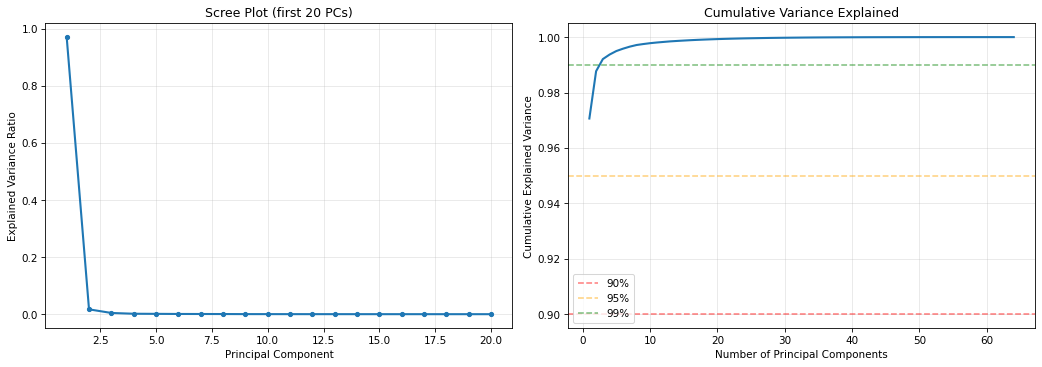

In [33]:
print('='*70)
print('5. EFFECTIVE DIMENSIONALITY (PCA)')
print('='*70)
print()

# Center data
W_centered = W - W.mean(axis=0)

# PCA
pca = PCA()
pca.fit(W_centered)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find how many PCs needed for 90%, 95%, 99% variance
n_90 = np.searchsorted(cumulative_variance, 0.90) + 1
n_95 = np.searchsorted(cumulative_variance, 0.95) + 1
n_99 = np.searchsorted(cumulative_variance, 0.99) + 1

print('Principal component analysis:')
print(f'  Top PC explains: {explained_variance_ratio[0]:.4f} ({explained_variance_ratio[0]*100:.2f}%)')
print(f'  Top 3 PCs explain: {cumulative_variance[2]:.4f} ({cumulative_variance[2]*100:.2f}%)')
print(f'  Top 10 PCs explain: {cumulative_variance[9]:.4f} ({cumulative_variance[9]*100:.2f}%)')
print()
print('Effective dimensionality:')
print(f'  90% variance: {n_90} dimensions')
print(f'  95% variance: {n_95} dimensions')
print(f'  99% variance: {n_99} dimensions')
print()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Left: Scree plot (explained variance per PC)
ax = axes[0]
ax.plot(range(1, min(21, len(explained_variance_ratio)+1)), 
        explained_variance_ratio[:20], 'o-', linewidth=2, markersize=4)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Scree Plot (first 20 PCs)')
ax.grid(alpha=0.3)

# Right: Cumulative variance
ax = axes[1]
ax.plot(range(1, len(cumulative_variance)+1), cumulative_variance, linewidth=2)
ax.axhline(0.90, color='r', linestyle='--', alpha=0.5, label='90%')
ax.axhline(0.95, color='orange', linestyle='--', alpha=0.5, label='95%')
ax.axhline(0.99, color='green', linestyle='--', alpha=0.5, label='99%')
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('Cumulative Variance Explained')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('='*70)

## 6. Sky Map (Directional Distribution)

6. DIRECTIONAL DISTRIBUTION (SKY MAP)

Projected to top 3 PCs (explaining 99.21% of variance)



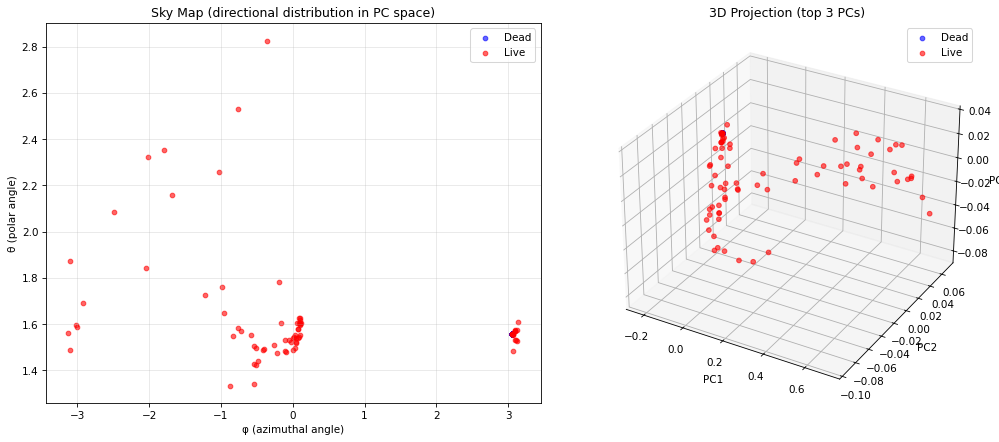

In [34]:
print('='*70)
print('6. DIRECTIONAL DISTRIBUTION (SKY MAP)')
print('='*70)
print()

# Convert to spherical coordinates
norms = np.linalg.norm(W, axis=1, keepdims=True)
W_normalized = W / (norms + 1e-10)  # Avoid div by zero

# For visualization, project to first 3 PCs
pca_3d = PCA(n_components=3)
W_3d = pca_3d.fit_transform(W_centered)

# Spherical coordinates from 3D projection
x, y, z = W_3d[:, 0], W_3d[:, 1], W_3d[:, 2]
r = np.sqrt(x**2 + y**2 + z**2)
theta = np.arccos(np.clip(z / (r + 1e-10), -1, 1))  # Polar angle
phi = np.arctan2(y, x)  # Azimuthal angle

print(f'Projected to top 3 PCs (explaining {pca_3d.explained_variance_ratio_.sum():.2%} of variance)')
print()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=DPI)

# Left: Sky map (θ vs φ)
ax = axes[0]
if DEAD_TOKENS is not None and LIVE_TOKENS is not None:
    dead_mask = np.isin(np.arange(n_tokens), DEAD_TOKENS)
    live_mask = np.isin(np.arange(n_tokens), LIVE_TOKENS)
    ax.scatter(phi[dead_mask], theta[dead_mask], s=20, alpha=0.6, label='Dead', color='blue')
    ax.scatter(phi[live_mask], theta[live_mask], s=20, alpha=0.6, label='Live', color='red')
    ax.legend()
else:
    ax.scatter(phi, theta, s=20, alpha=0.6)
ax.set_xlabel('φ (azimuthal angle)')
ax.set_ylabel('θ (polar angle)')
ax.set_title('Sky Map (directional distribution in PC space)')
ax.grid(alpha=0.3)

# Right: 3D scatter (PC1 vs PC2 vs PC3)
ax = axes[1]
ax.remove()  # Remove 2D axis
ax = fig.add_subplot(122, projection='3d')

if DEAD_TOKENS is not None and LIVE_TOKENS is not None:
    ax.scatter(W_3d[dead_mask, 0], W_3d[dead_mask, 1], W_3d[dead_mask, 2], 
               s=20, alpha=0.6, label='Dead', color='blue')
    ax.scatter(W_3d[live_mask, 0], W_3d[live_mask, 1], W_3d[live_mask, 2], 
               s=20, alpha=0.6, label='Live', color='red')
    ax.legend()
else:
    ax.scatter(W_3d[:, 0], W_3d[:, 1], W_3d[:, 2], s=20, alpha=0.6)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Projection (top 3 PCs)')

plt.tight_layout()
plt.show()

print('='*70)

## 7. Dead vs Live Geometric Separation

In [35]:
if DEAD_TOKENS is not None and LIVE_TOKENS is not None:
    print('='*70)
    print('7. DEAD vs LIVE GEOMETRIC SEPARATION')
    print('='*70)
    print()
    
    dead_mask = np.isin(np.arange(n_tokens), DEAD_TOKENS)
    live_mask = np.isin(np.arange(n_tokens), LIVE_TOKENS)
    
    W_dead = W[dead_mask]
    W_live = W[live_mask]
    
    # Centroids
    centroid_dead = W_dead.mean(axis=0)
    centroid_live = W_live.mean(axis=0)
    centroid_distance = np.linalg.norm(centroid_dead - centroid_live)
    
    # Intra-group distances (within dead, within live)
    if len(W_dead) > 1:
        dead_intra_distances = pdist(W_dead)
        dead_intra_mean = dead_intra_distances.mean()
    else:
        dead_intra_mean = 0.0
    
    if len(W_live) > 1:
        live_intra_distances = pdist(W_live)
        live_intra_mean = live_intra_distances.mean()
    else:
        live_intra_mean = 0.0
    
    # Inter-group distances (dead to live)
    inter_distances = []
    for i in DEAD_TOKENS:
        for j in LIVE_TOKENS:
            inter_distances.append(distances_matrix[i, j])
    inter_distances = np.array(inter_distances)
    inter_mean = inter_distances.mean()
    
    print('Centroid separation:')
    print(f'  Dead centroid norm: {np.linalg.norm(centroid_dead):.6f}')
    print(f'  Live centroid norm: {np.linalg.norm(centroid_live):.6f}')
    print(f'  Distance between centroids: {centroid_distance:.6f}')
    print()
    
    print('Intra-group distances (within population):')
    print(f'  Dead tokens: mean = {dead_intra_mean:.6f}')
    print(f'  Live tokens: mean = {live_intra_mean:.6f}')
    print()
    
    print('Inter-group distances (between populations):')
    print(f'  Dead-to-live: mean = {inter_mean:.6f}')
    print()
    
    # Separation metric: how well separated are the groups?
    # Ratio of inter-group to intra-group distances
    avg_intra = (dead_intra_mean + live_intra_mean) / 2
    separation_ratio = inter_mean / avg_intra if avg_intra > 0 else np.inf
    
    print(f'Separation metric (inter/intra): {separation_ratio:.2f}')
    if separation_ratio > 2:
        print('  → WELL SEPARATED (distinct populations)')
    elif separation_ratio > 1.2:
        print('  → MODERATELY SEPARATED')
    else:
        print('  → POORLY SEPARATED (overlapping)')
    
    print('='*70)
else:
    print('No dead/live token labels available. Skipping geometric separation analysis.')

7. DEAD vs LIVE GEOMETRIC SEPARATION

Centroid separation:
  Dead centroid norm: 0.809966
  Live centroid norm: 0.905648
  Distance between centroids: 0.368295

Intra-group distances (within population):
  Dead tokens: mean = 0.000648
  Live tokens: mean = 0.339450

Inter-group distances (between populations):
  Dead-to-live: mean = 0.376017

Separation metric (inter/intra): 2.21
  → WELL SEPARATED (distinct populations)


## Summary Report

In [36]:
print('\n')
print('='*70)
print('SNAPSHOT CHARACTERIZATION SUMMARY')
print('='*70)
print()
print(f'Dataset: {RUN_NAME}')
print(f'Tokens: {n_tokens}')
print(f'Embedding dimension: {embedding_dim}')
print()

print('KEY FINDINGS:')
print()

print(f'1. NORMS:')
print(f'   Mean L2 norm = {norms.mean():.4f} ± {norms.std():.4f}')
print(f'   Range: [{norms.min():.4f}, {norms.max():.4f}]')
print()

print(f'2. DISTANCES:')
print(f'   Mean pairwise distance = {distances_condensed.mean():.4f}')
print(f'   Mean nearest neighbor = {nearest_distances[:, 0].mean():.4f}')
print()

print(f'3. CONNECTIVITY (threshold = {DISTANCE_THRESHOLD}):')
print(f'   Edges: {n_edges}')
print(f'   Components: {len(components)}')
print(f'   Largest component: {component_sizes_sorted[0]} tokens ({component_sizes_sorted[0]/n_tokens:.1%})')
print()

print(f'4. DIMENSIONALITY:')
print(f'   PC1 explains {explained_variance_ratio[0]:.1%}')
print(f'   {n_90} dims for 90% variance')
print(f'   {n_99} dims for 99% variance')
print()

if DEAD_TOKENS is not None and LIVE_TOKENS is not None:
    print(f'5. DEAD vs LIVE:')
    print(f'   Dead tokens: {len(DEAD_TOKENS)} (mean norm = {norms[dead_mask].mean():.4f})')
    print(f'   Live tokens: {len(LIVE_TOKENS)} (mean norm = {norms[live_mask].mean():.4f})')
    print(f'   Centroid separation: {centroid_distance:.4f}')
    print(f'   Separation ratio: {separation_ratio:.2f}')

print('='*70)



SNAPSHOT CHARACTERIZATION SUMMARY

Dataset: 1.9c at step 1000 (Adam, lr=1e-3)
Tokens: 128
Embedding dimension: 64

KEY FINDINGS:

1. NORMS:
   Mean L2 norm = 0.8881 ± 0.1306
   Range: [0.8009, 1.2973]

2. DISTANCES:
   Mean pairwise distance = 0.3059
   Mean nearest neighbor = 0.0260

3. CONNECTIVITY (threshold = 0.01):
   Edges: 1329
   Components: 71
   Largest component: 56 tokens (43.8%)

4. DIMENSIONALITY:
   PC1 explains 97.1%
   1 dims for 90% variance
   3 dims for 99% variance

5. DEAD vs LIVE:
   Dead tokens: 50 (mean norm = 0.8100)
   Live tokens: 78 (mean norm = 0.9383)
   Centroid separation: 0.3683
   Separation ratio: 2.21
